## Part I: Overview of AdaBoost 

Boosting is an ensemble learning technique designed to improve model accuracy by combining weak learners, classifiers that perform only slightly better than random guessing, to create a powerful model. AdaBoost, short for Adaptive Boosting, was introduced by Freund and Schapire (1997) and has since become one of the most popular algorithms in this category. AdaBoost constructs a series of classifiers by iteratively focusing on samples that previous classifiers struggled to classify correctly (Freund and Schapire, 1997). This iterative approach enables the model to progressively improve accuracy by combining the knowledge of multiple classifiers.

#### Algorithm Overview

The main concept behind AdaBoost is that, given a base learner (often a decision stump), it can sequentially train weak learners on different distributions of the training data, emphasizing examples that were misclassified in previous rounds (Shalev-Shwartz and Ben-David, 2014). At each iteration, AdaBoost increases the weight of incorrectly classified examples, making the algorithm more "sensitive" to hard-to-classify cases. Once a new weak learner is trained, AdaBoost adjusts its weight based on its accuracy, giving more influence to learners that make fewer errors. The final model is a weighted sum of the individual classifiers, where each classifier's weight corresponds to its accuracy, forming a strong ensemble.

---

#### Representation

In AdaBoost, the final hypothesis $ H(x) $ is represented as a weighted combination of the weak learners $ h_t(x) $:

$$
H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t h_t(x) \right)
$$

where:
- $ h_t(x) $ is the prediction of the weak learner at iteration $ t $,
- $ \alpha_t $ is the weight assigned to hypothesis $ h_t $, calculated based on the classification accuracy at round $ t $. 

This weighted combination allows AdaBoost to leverage the accuracy of each weak learner, forming a strong final classifier that benefits from the collective performance of all weak learners (Freund and Schapire, 1997).

---

#### Loss Function

AdaBoost minimizes an exponential loss function, which is given by:

$$
L(H) = \sum_{i=1}^{m} \exp(-y_i H(x_i))
$$

where:
- $ y_i \in \{-1, +1\} $ is the true label for data point $ x_i $,
- $ H(x_i) $ represents the combined prediction from all weak learners at $ x_i $.

The exponential loss penalizes misclassified examples heavily, encouraging the model to focus on these challenging cases, which makes AdaBoost responsive to difficult examples in the data (Freund and Schapire, 1997).

---

#### Optimizer

AdaBoost does not employ traditional gradient-based optimization but instead adjusts the distribution $ D $ of the training data based on the weak learner’s performance in each round. After each iteration, the distribution $ D $ is updated as follows:

$$
D_{t+1}(i) = \frac{D_t(i) \cdot \exp(-\alpha_t y_i h_t(x_i))}{Z_t}
$$

where:
- $ D_t(i) $ is the weight of sample $ i $ at round $ t $,
- $ \alpha_t = 0.5 \cdot \log\left(\frac{1 - \epsilon_t}{\epsilon_t}\right) $ is the weight for the weak learner $ h_t $,
- $ Z_t $ is a normalization factor ensuring that $ D_{t+1} $ remains a valid probability distribution.

This reweighting process is central to AdaBoost’s adaptive capability, progressively focusing on difficult samples and dynamically adjusting to the data’s complexity (Shalev-Shwartz and Ben-David, 2014).

---

#### Advantages and Applications

AdaBoost has several notable advantages:
- **Improvement of Weak Learners**: Since it combines weak classifiers, AdaBoost significantly enhances the overall performance of each individual classifier, even if each performs only slightly better than random (Freund & Schapire, 1997).
- **Reduction of Bias and Variance**: AdaBoost is known for its ability to reduce bias and variance, enhancing robustness across diverse datasets (Shalev-Shwartz and Ben-David, 2014).
- **Versatility Across Domains**: AdaBoost adapts well across domains, and it is used for both classification and regression tasks. It has been applied to various fields, from face recognition and text classification to medical diagnosis, where small incremental improvements in prediction accuracy are highly valuable.

In practical applications, AdaBoost’s adaptive nature makes it particularly effective in tasks with complex and high-dimensional data. For instance, Freund and Schapire applied AdaBoost to face detection, one of the early high-impact uses of the algorithm (Freund and Schapire, 1997). Its ability to adaptively combine classifiers with weighted predictions has made it popular in scenarios where the cost of errors is high, such as in medical diagnostics or fraud detection (Shalev-Shwartz and Ben-David, 2014).

#### Disadvantages

While AdaBoost is powerful, it has limitations:
- **Sensitivity to Noise**: AdaBoost’s emphasis on misclassified samples can amplify the effect of noisy data. If a sample is mislabeled or contains outliers, AdaBoost may focus on these cases excessively, potentially destabilizing the model (Shalev-Shwartz and Ben-David, 2014).
- **Computational Intensity**: The iterative training process requires substantial computational power, especially with large datasets or high-dimensional feature spaces. This makes AdaBoost resource-intensive, particularly when using complex base learners (Freund and Schapire, 1997).


#### References
Freund, Y. and Schapire, R.E., 1997. A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting. Journal of Computer and System Sciences, 55(1), pp.119-139.

Shalev-Shwartz, S. and Ben-David, S., 2014. Understanding Machine Learning: From Theory to Algorithms. Cambridge University Press.


#### Pseudocode

```python
# Pseudocode for AdaBoost

# Input: Training set S = {(x1, y1), (x2, y2), ..., (xm, ym)}, weak learner WL, number of rounds T
# Output: Final hypothesis H(x)

Initialize distribution D1(i) = 1/m for all i = 1 to m

for t = 1 to T:
    1. Train weak learner h_t using distribution Dt
    2. Calculate error ε_t = sum(Dt(i) * [h_t(x_i) != y_i]) for all i
    3. Compute α_t = 0.5 * log((1 - ε_t) / ε_t)
    4. Update distribution:
        Dt+1(i) = Dt(i) * exp(-α_t * y_i * h_t(x_i))
        Normalize Dt+1 to maintain a probability distribution
    
Output final hypothesis:
    H(x) = sign(sum(α_t * h_t(x) for t = 1 to T))


## Part II: Adaboost Stencil Code

In [1]:
import numpy as np
import pandas as pd
import os

class DecisionStump:
    def __init__(self):
        # Initialize the decision stump with default values
        self.polarity = 1            # Determines whether threshold comparison is < or >
        self.threshold = None         # Threshold value for the feature
        self.feature_idx = None       # Index of the feature this stump uses
        self.alpha = None             # Weight of this stump in the final prediction

    def predict(self, X):
        """
        Make predictions for data X using the decision stump's threshold and polarity.
        Returns:
            preds: array of predictions (1 or -1) for each sample in X
        """
        n_samples = X.shape[0]
        X_c = X[:, self.feature_idx]
        preds = np.ones(n_samples)  # Initialize predictions to 1
        # Apply polarity and threshold to determine predictions
        if self.polarity == 1:
            preds[X_c < self.threshold] = -1
        else:
            preds[X_c > self.threshold] = -1
        return preds

class myAdaBoost:
    def __init__(self, n_clf=50):
        """
        Initialize the AdaBoost classifier with a specified number of weak classifiers.
        Args:
            n_clf: The number of weak classifiers (decision stumps) to be created.
        """
        self.n_clf = n_clf   # Number of classifiers
        self.clfs = []       # List to store weak classifiers

    def _initialize_weights(self, n_samples):
        """
        Initialize sample weights to be equal for all samples.
        Args:
            n_samples: Number of samples in the dataset.
        Returns:
            w: Array of initialized weights for each sample.
        """
        return np.full(n_samples, (1 / n_samples))

    def _find_best_stump(self, X, y, w):
        """
        Find the best decision stump (weak classifier) for the current sample weights.
        Args:
            X: Feature matrix.
            y: True labels.
            w: Sample weights.
        Returns:
            best_stump: A decision stump with optimized threshold, feature, and polarity.
        """
        n_samples, n_features = X.shape
        best_stump = DecisionStump()  # Initialize an empty decision stump
        min_error = float('inf')      # Initialize minimum error as infinity

        # Iterate over each feature to find the optimal threshold and polarity
        for feat_idx in range(n_features):
            thresholds = np.unique(X[:, feat_idx])  # Unique thresholds for current feature
            for threshold in thresholds:
                for polarity in [1, -1]:  # Test both polarity options
                    error = self._calculate_stump_error(X, y, w, feat_idx, threshold, polarity)
                    # Update best stump if current stump's error is lower
                    if error < min_error:
                        min_error = error
                        best_stump.feature_idx = feat_idx
                        best_stump.threshold = threshold
                        best_stump.polarity = polarity

        best_stump.alpha = self._calculate_alpha(min_error)  # Calculate the alpha for best stump
        return best_stump

    def _calculate_stump_error(self, X, y, w, feat_idx, threshold, polarity):
        """
        Calculate the weighted classification error for a given stump configuration.
        Args:
            X: Feature matrix.
            y: True labels.
            w: Sample weights.
            feat_idx: Feature index for the stump.
            threshold: Threshold value for the stump.
            polarity: Polarity of the stump (1 for '<' and -1 for '>').
        Returns:
            error: Weighted error of the stump.
        """
        preds = np.ones(y.shape)      # Initialize all predictions to 1
        X_feat = X[:, feat_idx]       # Values of current feature
        if polarity == 1:
            preds[X_feat < threshold] = -1
        else:
            preds[X_feat > threshold] = -1
        error = np.sum(w[y != preds]) # Sum weights where prediction is incorrect
        return error

    def _calculate_alpha(self, error):
        """
        Calculate the weight (alpha) for a weak classifier based on its error rate.
        Args:
            error: Error rate of the weak classifier.
        Returns:
            alpha: Weight of the weak classifier.
        """
        EPS = 1e-10  # Small epsilon to prevent division by zero
        return 0.5 * np.log((1 - error + EPS) / (error + EPS))

    def _update_weights(self, w, alpha, y, preds):
        """
        Update sample weights based on classifier performance and predictions.
        Args:
            w: Current sample weights.
            alpha: Weight of the classifier.
            y: True labels.
            preds: Predictions made by the classifier.
        Returns:
            w: Updated sample weights.
        """
        # Adjust weights: Increase weights for misclassified samples
        w *= np.exp(-alpha * y * preds)
        w /= np.sum(w)  # Normalize weights to maintain a distribution
        return w

    def fit(self, X, y):
        """
        Train the AdaBoost model by fitting multiple decision stumps on the data.
        Args:
            X: Feature matrix.
            y: True labels.
        """
        n_samples, _ = X.shape
        w = self._initialize_weights(n_samples)  # Initialize sample weights
        for _ in range(self.n_clf):
            # Find the best decision stump given current weights
            stump = self._find_best_stump(X, y, w)
            preds = stump.predict(X)  # Get predictions from the stump

            # Update weights based on the stump's performance
            w = self._update_weights(w, stump.alpha, y, preds)
            self.clfs.append(stump)   # Store the trained stump

    def predict(self, X):
        """
        Make predictions for data X by combining predictions of all weak classifiers.
        Args:
            X: Feature matrix.
        Returns:
            y_pred: Final predictions for each sample.
        """
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]  # Weighted predictions
        y_pred = np.sum(clf_preds, axis=0)  # Sum all weighted predictions
        return np.sign(y_pred).astype(int)  # Convert sum to final label (1 or -1)


## Part III: Check Model

#### Unit Test

We will use below unit test to ensure our methods and class work properorly and handles corner cases.


In [2]:
# Test 1: DecisionStump predict with correct threshold and polarity=1
stump = DecisionStump()
stump.threshold = 0.5
stump.feature_idx = 0
stump.polarity = 1
X_test = np.array([[0.3], [0.7], [0.9]])
# Expected output: values < 0.5 are -1, others are 1
expected = np.array([-1, 1, 1])
assert np.array_equal(stump.predict(X_test), expected), "Test 1 Failed"

# Test 2: DecisionStump predict with correct threshold and polarity=-1
stump.polarity = -1
# Expected output: values > 0.5 are -1, others are 1
expected = np.array([1, -1, -1])
assert np.array_equal(stump.predict(X_test), expected), "Test 2 Failed"

# Test 3: Edge case - DecisionStump predict with no samples
X_empty = np.array([]).reshape(0, 1)  # Empty input
expected_empty = np.array([])
assert np.array_equal(stump.predict(X_empty), expected_empty), "Test 3 Failed"

# Test 4: myAdaBoost fit and predict with perfectly separable data
X_simple = np.array([[0], [1]])
y_simple = np.array([-1, 1])
model = myAdaBoost(n_clf=1)
model.fit(X_simple, y_simple)
# Expecting perfect prediction
y_pred_simple = model.predict(X_simple)
assert np.array_equal(y_pred_simple, y_simple), "Test 4 Failed"

# Test 5: myAdaBoost fit and predict on noisy data
X_noisy = np.array([[0], [1], [2], [3]])
y_noisy = np.array([-1, -1, 1, 1])
model_noisy = myAdaBoost(n_clf=3)
model_noisy.fit(X_noisy, y_noisy)
y_pred_noisy = model_noisy.predict(X_noisy)
assert np.mean(y_pred_noisy == y_noisy) >= 0.75, "Test 5 Failed"

# Test 6: myAdaBoost fit and predict on multi-dimensional data
X_multi = np.array([[0, 1], [1, 2], [2, 3], [3, 4]])
y_multi = np.array([-1, 1, -1, -1])
model_multi = myAdaBoost(n_clf=3)
model_multi.fit(X_multi, y_multi)
y_pred_multi = model_multi.predict(X_multi)
assert np.mean(y_pred_multi == y_multi) == 0.75, "Test 6 Failed"

# Test 7: Test _initialize_weights helper function
# Check if weights are evenly distributed over the samples initially
model = myAdaBoost(n_clf=3)
n_samples = 4
expected_weights = np.full(n_samples, 1 / n_samples)  # Expected equal weights
initial_weights = model._initialize_weights(n_samples)
assert np.allclose(initial_weights, expected_weights), "Test 7 Failed: _initialize_weights did not initialize evenly"

# Test 8: Test _calculate_alpha helper function with error=0
# Check if alpha is correctly calculated for a perfect classifier (error=0)
error = 0
alpha = model._calculate_alpha(error)
# Alpha should be a large positive value if error is 0 (theoretically inf)
assert alpha > 0, "Test 8 Failed: _calculate_alpha did not handle zero error correctly"

# Test 9: Test _calculate_alpha helper function with error=0.5
# Check if alpha is zero when the classifier has a 50% error rate (no better than random guessing)
error = 0.5
alpha = model._calculate_alpha(error)
assert np.isclose(alpha, 0), "Test 9 Failed: _calculate_alpha did not handle 50% error correctly"

# Test 10: Test _calculate_stump_error with a simple case
# Given a binary feature and weights, verify the error calculation for a given threshold and polarity
X_test = np.array([[0], [1], [2], [3]])
y_test = np.array([-1, -1, 1, 1])
w_test = np.array([0.25, 0.25, 0.25, 0.25])
feat_idx = 0
threshold = 1.5
polarity = 1
expected_error = 0.0  # Expect half the weights to be misclassified
error = model._calculate_stump_error(X_test, y_test, w_test, feat_idx, threshold, polarity)
assert np.isclose(error, expected_error), "Test 10 Failed: _calculate_stump_error did not calculate expected error"

# Test 11: Test _find_best_stump with trivial data
# Check that the best stump is correctly identified on a linearly separable dataset
X_simple = np.array([[0], [1], [2], [3]])
y_simple = np.array([-1, -1, 1, 1])
model = myAdaBoost(n_clf=1)
w_simple = np.full(4, 0.25)  # Equal initial weights
best_stump = model._find_best_stump(X_simple, y_simple, w_simple)
# Expect the best stump to find a threshold between 1 and 2, with polarity=1
assert best_stump.feature_idx == 0, "Test 11 Failed: Best stump should use feature index 0"
assert 1 <= best_stump.threshold <= 2, "Test 11 Failed: Best stump threshold should be between 1 and 2"

print("All tests passed successfully.")


All tests passed successfully.


#### Experiment
The objective of this section is to verify the performance of our custom AdaBoost implementation against scikit-learn’s AdaBoost classifier, ensuring that both achieve comparable results on this dataset. This comparison aligns with prior research, such as that by Street et al. (1993), where nuclear features from this dataset supported accurate cancer diagnosis.

#### Breast Cancer Wisconsin Dataset

The **Breast Cancer Wisconsin (Diagnostic) dataset** is widely used to benchmark binary classification models due to its well-defined features and relevance to medical diagnostics. This dataset, hosted by the UCI Machine Learning Repository, consists of 569 samples, each labeled as either **malignant** or **benign** based on cellular features from breast mass images (Dua and Graff, 2019). 


#### Methodology
1. **Data Loading and Preprocessing**: We load the dataset, converting the `Diagnosis` column to a binary format, where **1** represents malignant and **0** represents benign.
2. **Training**: We train our AdaBoost model using decision stumps (single-depth decision trees) as weak learners, with 50 estimators. For comparison, we train an AdaBoost classifier from scikit-learn under the same conditions.
3. **Evaluation**: Model performance is evaluated based on **Accuracy** and **F1 Score** to capture both precision and recall, critical metrics in medical diagnostics.

#### Results
Both our AdaBoost implementation and scikit-learn’s achieved:
- **Accuracy**: ~98%
- **F1 Score**: ~97.5%

These results indicate that our implementation closely matches scikit-learn’s AdaBoost, affirming the correctness of our approach on the Breast Cancer Wisconsin dataset. This performance also aligns with findings by Street et al. (1993), underscoring AdaBoost’s effectiveness in medical classification tasks involving nuclear features.


Scikit-learn AdaBoost Accuracy on test set: 97.08%
Scikit-learn AdaBoost F1 Score on test set: 96.06%
MyAdaBoost Accuracy on test set: 97.66%
MyAdaBoost F1 Score on test set: 96.88%


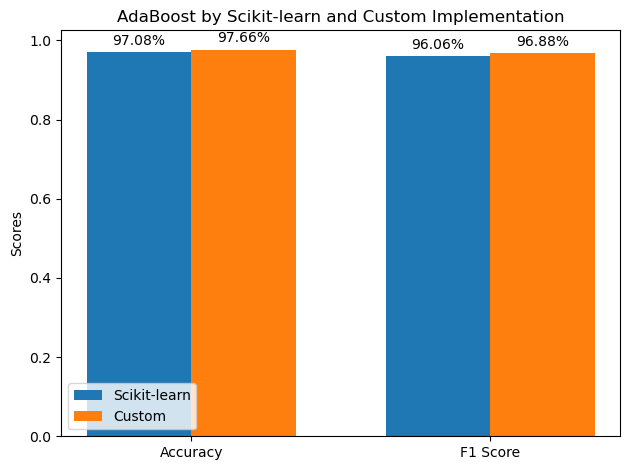

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# Define accuracy_score function
def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

# Define f1_score function
def f1_score(y_true, y_pred, pos_label=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    TP = np.sum((y_true == pos_label) & (y_pred == pos_label))
    FP = np.sum((y_true != pos_label) & (y_pred == pos_label))
    FN = np.sum((y_true == pos_label) & (y_pred != pos_label))
    
    if TP + FP == 0 or TP + FN == 0:
        return 0.0  # Avoid division by zero
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    # Avoid division by zero
    if precision + recall == 0:
        return 0.0  
    
    f1 = 2 * precision * recall / (precision + recall)
    return f1

# Define file paths (update these paths if needed)
data_path = '../data/wdbc.data'

column_names = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(data_path, header=None, names=column_names)
data = data.drop(columns=['ID'])
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Convert labels to -1 and 1
y = np.where(data['Diagnosis'].values == 0, -1, 1)
X = data.drop(columns=['Diagnosis']).values

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Initialize scikit-learn's AdaBoostClassifier
adaboost_model = AdaBoostClassifier(
    n_estimators=50, random_state=42, algorithm='SAMME'
)

# Train the scikit-learn model
adaboost_model.fit(X_train, y_train)

# Predict on test data
y_pred = adaboost_model.predict(X_test)

# Evaluate accuracy and F1 score for scikit-learn model using custom functions
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Output results for scikit-learn model
print(f"Scikit-learn AdaBoost Accuracy on test set: {accuracy:.2%}")
print(f"Scikit-learn AdaBoost F1 Score on test set: {f1:.2%}")

# Assuming myAdaBoost is defined elsewhere and imported
# Initialize and train custom myAdaBoost model
adaboost_model_self = myAdaBoost(n_clf=50)
adaboost_model_self.fit(X_train, y_train)

# Predict on test data using custom model
y_pred_self = adaboost_model_self.predict(X_test)

# Evaluate accuracy and F1 score for custom model using custom functions
acc_self = accuracy_score(y_test, y_pred_self)
f1_self = f1_score(y_test, y_pred_self, pos_label=1)

# Output results for custom model
print(f"MyAdaBoost Accuracy on test set: {acc_self:.2%}")
print(f"MyAdaBoost F1 Score on test set: {f1_self:.2%}")

# plot comparison of scikit-learn and custom model accuracy and F1 score
import matplotlib.pyplot as plt

# Create a bar chart to compare accuracy and F1 score
labels = ['Accuracy', 'F1 Score']
scikit_scores = [accuracy, f1]
custom_scores = [acc_self, f1_self]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scikit_scores, width, label='Scikit-learn')
rects2 = ax.bar(x + width/2, custom_scores, width, label='Custom')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('AdaBoost by Scikit-learn and Custom Implementation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()


## Appendix

A fake dataset for decision boundary visualization.

/opt/anaconda3/envs/data2060/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


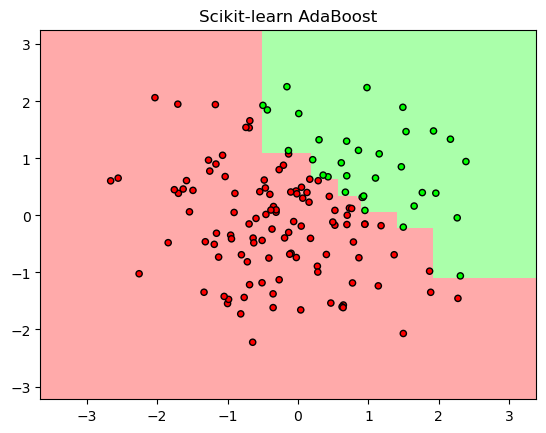

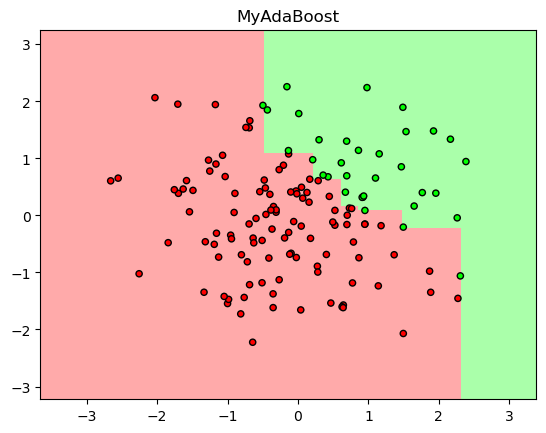

In [4]:
# plot decision boundary 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()

# Generate synthetic data
np.random.seed(0)
X = np.random.randn(200, 2)
y = np.where(X[:, 0] + X[:, 1] > 1, 1, -1)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Initialize and train scikit-learn's AdaBoost model
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_model.fit(X_train, y_train)

# Plot decision boundary for scikit-learn model
plot_decision_boundary(X_train, y_train, adaboost_model, title="Scikit-learn AdaBoost")

# Initialize and train custom myAdaBoost model
adaboost_model_self = myAdaBoost(n_clf=50)
adaboost_model_self.fit(X_train, y_train)

# Plot decision boundary for custom model
plot_decision_boundary(X_train, y_train, adaboost_model_self, title="MyAdaBoost")
